In [28]:
# Remove all existing TensorFlow installations
#%pip uninstall -y tensorflow tensorflow-cpu tensorflow-gpu protobuf keras-ocr
#%pip cache purge

# Install specific versions with --no-deps to prevent auto-upgrades
#%pip install tensorflow-gpu==2.10.0 --no-deps
#%pip install tensorflow-cpu==2.10.0 --no-deps
#%pip install tensorflow==2.10.0 --no-deps
#%pip install protobuf==3.20.3 --no-deps
#%pip install keras-ocr==0.8.9
#%pip install python-Levenshtein
#%pip install pytesseract
#%pip install easyocr

In [29]:
# Ensure TensorFlow is imported correctly
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.10.0


In [30]:
import os
from difflib import SequenceMatcher
import Levenshtein
import time

# Directories
expected_output_directory = 'cleaned/000'
actual_output_directory = 'outputs/py_cleaned'

def cleanTextFile(text):
    return text.replace('\n', ' ')
    

# METHOD 1:
# Similarity percentage using Levenshtein distance (edit distance), more robust for OCR
# Levenshtein distance outputs how similar, not dis-similar
def calculate_similarity_lev(text1, text2):
    text1 = cleanTextFile(text1)
    text2 = cleanTextFile(text2)
    print(f"Predicted: {text1}")
    print(f"Truth: {text2}")
    
    distance = Levenshtein.distance(text1, text2)
    max_length = max(len(text1), len(text2))
    if max_length == 0:  # Avoids dividing by zero
        return 100.0
    return (1 - distance / max_length) * 100

# METHOD 2:
def calculate_similarity(text1, text2): 
    return SequenceMatcher(None, text1, text2).ratio() * 100


def openCalculate(path):
    result = ''
    if os.path.exists(path):
                with open(path, 'r') as f:
                    result = f.read()
    return result

In [31]:
import cv2
from PIL import Image
import numpy as np

#NOT SURE ABOUT THIS
#def cleanImage(image):
#    # Convert PIL Image to numpy array if needed (NOT POSSIBLE WITH NORMAL CV2 SINCE PIL IMAGE)
#    if isinstance(image, Image.Image):
#        image = np.array(image)
#        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) #need for below
#    if len(image.shape) == 3:
#        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#
#    image = cv2.fastNlMeansDenoising(image, None, 10, 7, 21)
#    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
#    return image

def cleanImage(image, for_ocr):
    image = np.array(image)  # Convert to NumPy array
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    
    if for_ocr == "tesseract":
        image = cv2.GaussianBlur(image, (5, 5), 0)  # Reduce noise
        _, image = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY)  # Binarization
        return Image.fromarray(image)  # Convert back to PIL Image
    
    elif for_ocr == "keras":
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # Convert back to RGB
        return image  # Return NumPy array for Keras-OCR
    
    elif for_ocr == "easyocr":
        return image  # Keep as NumPy array
    
    else:
        raise ValueError("Invalid OCR type. Use 'tesseract', 'keras', or 'easyocr'.")


In [32]:
def loadDataAll(groundTruthDir, pyTesseractOutputTyped, pyTesseractOutputWritten, 
                kerasOCROutputTyped, kerasOCROutputWritten, easyOCROutputTyped, easyOCROutputWritten):
    count = 0
    pyTesseractTypedScore = 0
    pyTesseractWrittenScore = 0
    kerasOCRTypedScore = 0
    kerasOCRWrittenScore = 0
    easyOCRTypedScore = 0
    easyOCRWrittenScore = 0

    for filename in os.listdir(groundTruthDir):
        if filename.endswith('.txt'):
            # Construct file paths
            groundTruthPath = os.path.join(groundTruthDir, filename)
            pyTesseractTypedPath = os.path.join(pyTesseractOutputTyped, filename)
            pyTesseractWrittenPath = os.path.join(pyTesseractOutputWritten, filename)
            kerasOCRTypedPath = os.path.join(kerasOCROutputTyped, filename)
            kerasOCRWrittenPath = os.path.join(kerasOCROutputWritten, filename)
            easyOCRTypedPath = os.path.join(easyOCROutputTyped, filename)
            easyOCRWrittenPath = os.path.join(easyOCROutputWritten, filename)
    
            # Read file contents
            groundTruthText = openCalculate(groundTruthPath)
            pyTesseractTypedText = openCalculate(pyTesseractTypedPath)
            pyTesseractWrittenText = openCalculate(pyTesseractWrittenPath)
            kerasOCRTypedText = openCalculate(kerasOCRTypedPath)
            kerasOCRWrittenText = openCalculate(kerasOCRWrittenPath)
            easyOCRTypedText = openCalculate(easyOCRTypedPath)
            easyOCRWrittenText = openCalculate(easyOCRWrittenPath)

            # Calculate similarities
            pyTesseractTypedScoreLev = calculate_similarity_lev(pyTesseractTypedText, groundTruthText)
            pyTesseractWrittenScoreLev = calculate_similarity_lev(pyTesseractWrittenText, groundTruthText)
            kerasOCRTypedScoreLev = calculate_similarity_lev(kerasOCRTypedText, groundTruthText)
            kerasOCRWrittenScoreLev = calculate_similarity_lev(kerasOCRWrittenText, groundTruthText)
            easyOCRTypedScoreLev = calculate_similarity_lev(easyOCRTypedText, groundTruthText)
            easyOCRWrittenScoreLev = calculate_similarity_lev(easyOCRWrittenText, groundTruthText)
            
            print("-----------------------------------------------------------------------------------------")
            print(f"File: {filename}")
            print(f"Similarity Percentage from Levenshtein with PyTesseract Typed: {pyTesseractTypedScoreLev:.2f}%")
            print(f"Similarity Percentage from Levenshtein with PyTesseract Written: {pyTesseractWrittenScoreLev:.2f}%")
            print(f"Similarity Percentage from Levenshtein with Keras OCR Typed: {kerasOCRTypedScoreLev:.2f}%")
            print(f"Similarity Percentage from Levenshtein with Keras OCR Written: {kerasOCRWrittenScoreLev:.2f}%")
            print(f"Similarity Percentage from Levenshtein with Easy OCR Typed: {easyOCRTypedScoreLev:.2f}%")
            print(f"Similarity Percentage from Levenshtein with Easy OCR Written: {easyOCRWrittenScoreLev:.2f}%")
            
            # Accumulate scores
            count += 1
            pyTesseractTypedScore += pyTesseractTypedScoreLev
            pyTesseractWrittenScore += pyTesseractWrittenScoreLev
            kerasOCRTypedScore += kerasOCRTypedScoreLev
            kerasOCRWrittenScore += kerasOCRWrittenScoreLev
            easyOCRTypedScore += easyOCRTypedScoreLev
            easyOCRWrittenScore += easyOCRWrittenScoreLev            
        else:
            print(f"Expected output not found for {filename}")

    # Calculate averages and return results
    if count > 0:
        result = {
            "pytesseract Typed": pyTesseractTypedScore / count,
            "pytesseract Written": pyTesseractWrittenScore / count,
            "kerasOCR Typed": kerasOCRTypedScore / count,
            "kerasOCR Written": kerasOCRWrittenScore / count,
            "easyOCR Typed": easyOCRTypedScore / count,
            "easyOCR Written": easyOCRWrittenScore / count
        }
        return result
    else:
        return None

# PyTesseract

In [33]:
import pytesseract
from PIL import Image
import os

#Tesseract executable
pytesseract.pytesseract.tesseract_cmd = "C:/Program Files/Tesseract-OCR/tesseract.exe"

imageWritten = 'cleaned/000-written'
imageTyped = 'cleaned/000-typed'

def processImagesPyTesseract(imageDirectory, outputDirectory, process):
    pyTesseractTimes = {}
    for filename in os.listdir(imageDirectory):

        if filename.endswith('.png'):
            image_path = os.path.join(imageDirectory, filename)

            # Open using PIL (Need to open with RGB and not BGR)
            img = Image.open(image_path)
            if process:
                img = cleanImage(img, "tesseract") 

            # Output file format
            output_file ="outputs/"+outputDirectory+"/" + os.path.splitext(filename)[0] + '.txt'

            # Run Tesseract and writes into output file
            with open(output_file, 'w') as f:
                startTime = time.time()
                text = pytesseract.image_to_string(img, config="--oem 3 --psm 6") #better for written notes (oem 3 is best OCR engine [LSTM + Legacy], psm 6 assumes block text) 
                endTime = time.time()
                pyTesseractTimes[filename] = endTime - startTime
                f.write(text)

            print(f"Text extracted from {filename} and saved to {output_file}")
    return pyTesseractTimes
#Uncomment to run PyTesseract on images
print("Processing images in directory (PyTesseract):", imageWritten)
pyTesseractWrittenTime= processImagesPyTesseract(imageWritten, "pyWritten", False)
print("\nProcessing images in directory  (PyTesseract):", imageTyped)
pyTesseractTypedTime=processImagesPyTesseract(imageTyped, "pyTyped", False)


Processing images in directory (PyTesseract): cleaned/000-written
Text extracted from a01-000.png and saved to outputs/pyWritten/a01-000.txt
Text extracted from a01-003.png and saved to outputs/pyWritten/a01-003.txt
Text extracted from a01-007.png and saved to outputs/pyWritten/a01-007.txt
Text extracted from a01-011.png and saved to outputs/pyWritten/a01-011.txt
Text extracted from a01-014.png and saved to outputs/pyWritten/a01-014.txt
Text extracted from a01-020.png and saved to outputs/pyWritten/a01-020.txt
Text extracted from a01-026.png and saved to outputs/pyWritten/a01-026.txt
Text extracted from a01-030.png and saved to outputs/pyWritten/a01-030.txt
Text extracted from a01-043.png and saved to outputs/pyWritten/a01-043.txt
Text extracted from a01-049.png and saved to outputs/pyWritten/a01-049.txt
Text extracted from a01-049x.png and saved to outputs/pyWritten/a01-049x.txt
Text extracted from a01-053.png and saved to outputs/pyWritten/a01-053.txt
Text extracted from a01-058.png 

In [34]:
#Need to run and then restart the kernel to use

#%pip uninstall -y keras-ocr
#%pip install keras==2.10.0
#%pip install h5py==3.7.0
#%pip install efficientnet-tfkeras==1.1.1
#%pip install keras-ocr==0.8.9

In [35]:
import tensorflow as tf
import keras
import keras_ocr

# Print versions to verify
print(f"TensorFlow version: {tf.version.VERSION}")
print(f"Keras version: {keras.__version__}")

# Initialize pipeline
pipeline = keras_ocr.pipeline.Pipeline()
print("Pipeline initialized successfully!")

TensorFlow version: 2.10.0
Keras version: 2.10.0
Looking for C:\Users\tyson\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\tyson\.keras-ocr\crnn_kurapan.h5
Pipeline initialized successfully!


# Keras-OCR

In [36]:
import matplotlib.pyplot as plt
import os
import keras_ocr
import numpy as np
# Process images using Keras OCR
def processImagesKerasOcr(imageDirectory, outputDirectory, process):
    kerasTimes = {}
    for filename in os.listdir(imageDirectory):
        if filename.endswith('.png'):
            image_path = os.path.join(imageDirectory, filename)

            img = Image.open(image_path).convert('RGB')
            if process:
                img = cleanImage(img, "keras") 
            else:
                img = np.array(img)  # Convert to numpy array (done in cleanImage)

            output_file = "outputs/" +outputDirectory+"/" +os.path.splitext(filename)[0] + '.txt'

            startTime = time.time()
            predictions = pipeline.recognize([img])[0]  # Get predictions for the image
            endTime = time.time()
            kerasTimes[filename] = endTime - startTime
            
            # Run Keras OCR and writes into output file
            with open(output_file, 'w') as f:
                for word, _ in predictions:
                    f.write(word + '\n')

            print(f"Text extracted from {filename} and saved to {output_file}")
    return kerasTimes

#Uncomment to run Keras OCR
print("Processing images in directory (Keras OCR):", imageWritten)
kerasWrittenTime=processImagesKerasOcr(imageWritten, "kerasWritten", False)
print("\nProcessing images in directory (Keras OCR):", imageTyped)
kerasTypedTime=processImagesKerasOcr(imageTyped, "kerasTyped", False)


Processing images in directory (Keras OCR): cleaned/000-written
2/2 [==============================] - 2s 492ms/step
Text extracted from a01-000.png and saved to outputs/kerasWritten/a01-000.txt
3/3 [==============================] - 2s 614ms/step
Text extracted from a01-003.png and saved to outputs/kerasWritten/a01-003.txt
3/3 [==============================] - 2s 469ms/step
Text extracted from a01-007.png and saved to outputs/kerasWritten/a01-007.txt
3/3 [==============================] - 2s 506ms/step
Text extracted from a01-011.png and saved to outputs/kerasWritten/a01-011.txt
2/2 [==============================] - 1s 673ms/step
Text extracted from a01-014.png and saved to outputs/kerasWritten/a01-014.txt
3/3 [==============================] - 2s 471ms/step
Text extracted from a01-020.png and saved to outputs/kerasWritten/a01-020.txt
3/3 [==============================] - 2s 600ms/step
Text extracted from a01-026.png and saved to outputs/kerasWritten/a01-026.txt
3/3 [==============

# EasyOCR

In [37]:
#%pip uninstall -y easyocr opencv-python-headless
#%pip install --user easyocr

### Here's how to run EasyOCR on windows:
1. Open the Start menu and search for "Environment Variables."
2. Click on "Edit the system environment variables."
3. In the System Properties window, click on the "Environment Variables" button.
4. Under "User variables," find the Path variable and click "Edit."
5. Add the directory Scripts as a new entry.
6. Click "OK" to save and close all windows.
7. Restart your terminal or IDE after making this change.
    1) eg C:\Users\adam4\AppData\Roaming\Python\Python39\Scripts\python.exe -m easyocr
8. Run: ```%pip install --upgrade Pillow``` and ```%pip show Pillow```

In [38]:
import easyocr
import os

reader = easyocr.Reader(['en'])

def processImagesEasyOcr(imageDirectory, outputDirectory, process):
    easyOCRTimes = {}
    for filename in os.listdir(imageDirectory):
        if filename.endswith('.png'):
            image_path = os.path.join(imageDirectory, filename)

            img = cv2.imread(image_path)
            if process:
                img = cleanImage(img, "easyocr")
                
            start = time.time()
            output = reader.readtext(img, detail=0)
            end = time.time()
            easyOCRTimes[filename] = end - start
            
            output_file ="outputs/"+outputDirectory+"/" + os.path.splitext(filename)[0] + '.txt'

            with open(output_file, 'w') as f:
                for line in output:
                    f.write(line + '\n')  

            print(f"Text for {filename} written to {output_file}")
    return easyOCRTimes

#uncomment to run Easy OCR
print("Processing images in directory (Easy OCR):", imageWritten)
easyWrittenTime=processImagesEasyOcr(imageWritten, "easy-ocrWritten", False)
print("\nProcessing images in directory (Easy OCR):", imageTyped)
easyTypedTime=processImagesEasyOcr(imageTyped, "easy-ocrTyped", False)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Processing images in directory (Easy OCR): cleaned/000-written
Text for a01-000.png written to outputs/easy-ocrWritten/a01-000.txt
Text for a01-003.png written to outputs/easy-ocrWritten/a01-003.txt
Text for a01-007.png written to outputs/easy-ocrWritten/a01-007.txt
Text for a01-011.png written to outputs/easy-ocrWritten/a01-011.txt
Text for a01-014.png written to outputs/easy-ocrWritten/a01-014.txt
Text for a01-020.png written to outputs/easy-ocrWritten/a01-020.txt
Text for a01-026.png written to outputs/easy-ocrWritten/a01-026.txt
Text for a01-030.png written to outputs/easy-ocrWritten/a01-030.txt
Text for a01-043.png written to outputs/easy-ocrWritten/a01-043.txt
Text for a01-049.png written to outputs/easy-ocrWritten/a01-049.txt
Text for a01-049x.png written to outputs/easy-ocrWritten/a01-049x.txt
Text for a01-053.png written to outputs/easy-ocrWritten/a01-053.txt
Text for a01-058.png written to outputs/easy-ocrWritten/a01-058.txt
Text for a01-063.png written to outputs/easy-ocrWri

# Running Comparison

In [39]:
# Load the data and calculate similarity scores
groundTruth = 'cleaned/000-truth'
pyTesseractOutputTyped = 'outputs/pyTyped'
pyTesseractOutputWritten = 'outputs/pyWritten'
kerasOCROutputTyped = 'outputs/kerasTyped'
kerasOCROutputWritten = 'outputs/kerasWritten'
easyOCROutputTyped = 'outputs/easy-ocrTyped'
easyOCROutputWritten = 'outputs/easy-ocrWritten'
result = loadDataAll(groundTruth, pyTesseractOutputTyped, pyTesseractOutputWritten, kerasOCROutputTyped, kerasOCROutputWritten, easyOCROutputTyped, easyOCROutputWritten)
print("---------------------------------------------------")
print("Final Results")
print("---------------------------------------------------")
print(f"Similarity Percentage from Levenshtein with PyTesseract Typed: {result['pytesseract Typed']:.2f}%")
print(f"Similarity Percentage from Levenshtein with PyTesseract Written: {result['pytesseract Written']:.2f}%")
print(f"Similarity Percentage from Levenshtein with Keras OCR Typed: {result['kerasOCR Typed']:.2f}%")
print(f"Similarity Percentage from Levenshtein with Keras OCR Written: {result['kerasOCR Written']:.2f}%")
print(f"Similarity Percentage from Levenshtein with Easy OCR Typed: {result['easyOCR Typed']:.2f}%")
print(f"Similarity Percentage from Levenshtein with Easy OCR Written: {result['easyOCR Written']:.2f}%")
print("---------------------------------------------------") 

Predicted: A MOVE to stop Mr. Gaitskell from nominating any more Labour life Peers is to be made at a meeting of Labour M Ps tomorrow. Mr. Michael Foot has put down a resolution on the subject and he is to be backed by Mr. Will Griffiths, MP for ‘Manchester Exchange. 
Truth: A MOVE to stop Mr. Gaitskell from nominating any more Labour Life Peers is to  be made at a meeting of Labour M Ps tomorrow. Mr. Michael Foot has put down a resolution on the subject and he is to be backed by Mr. Will Griffiths, M P for  Manchester Exhchange.
Predicted: Ak MOVE to dtoe Mr. Gatbkell from  woMi natn mag OMA ORR, Labour Ufe_ Poors  Wo to BR wade aka medina af Labour MPs touorroo, Myr, Michael Toot Kar Pre Aown a vesotution ou Lhe  oudjedy On WO lo do GA backeR by Mer. Wit Gags , WP Lor Moncrade, Cxoranae , 
Truth: A MOVE to stop Mr. Gaitskell from nominating any more Labour Life Peers is to  be made at a meeting of Labour M Ps tomorrow. Mr. Michael Foot has put down a resolution on the subject and he 

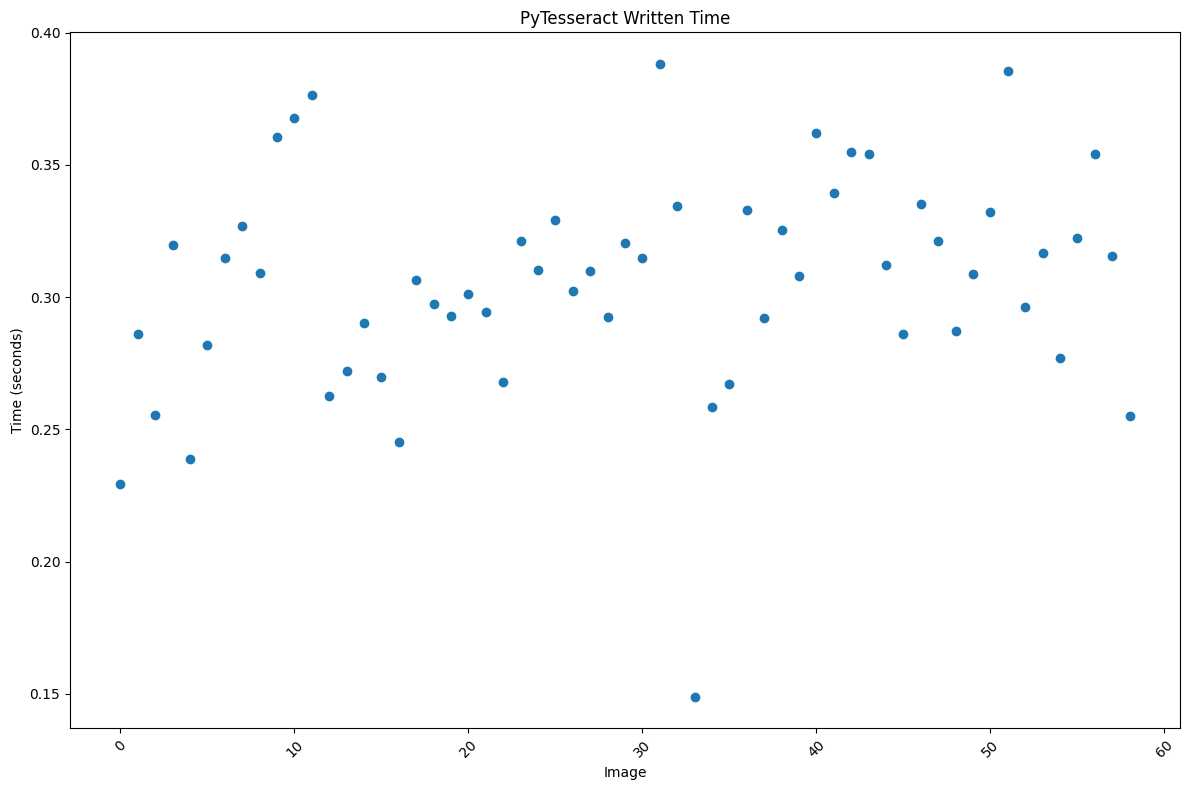

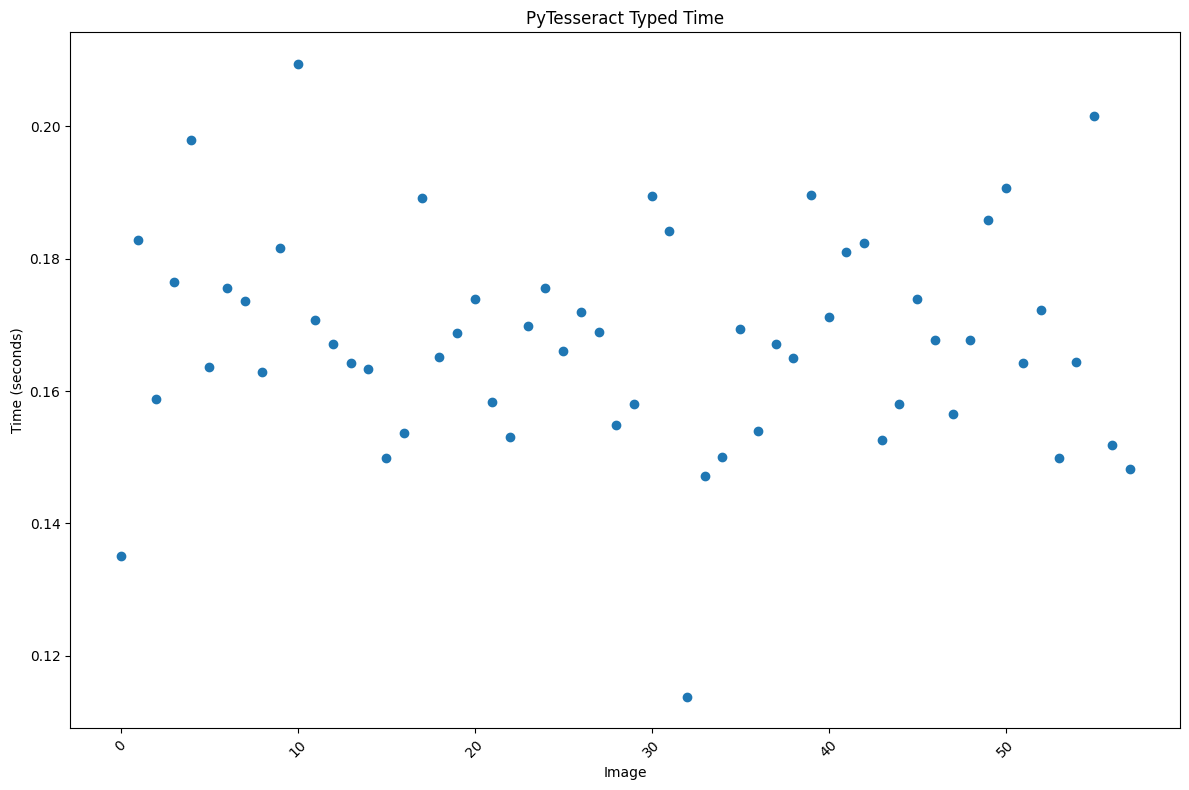

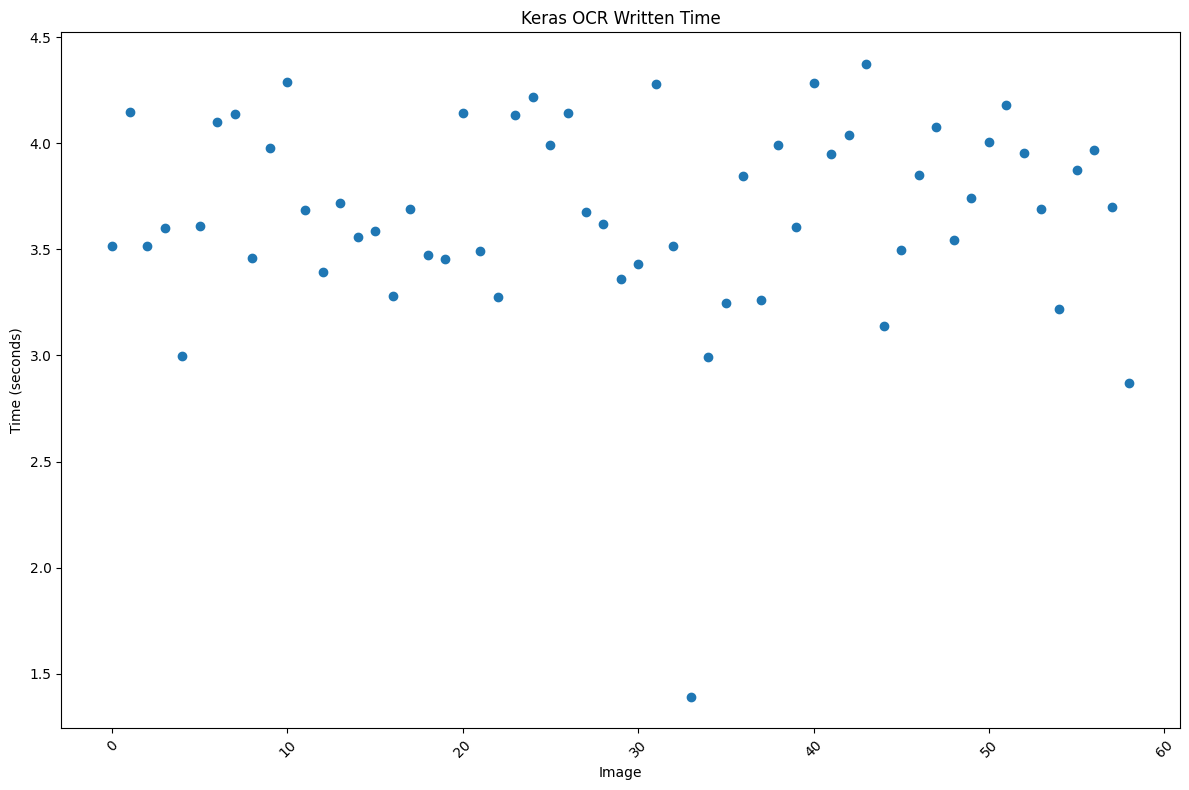

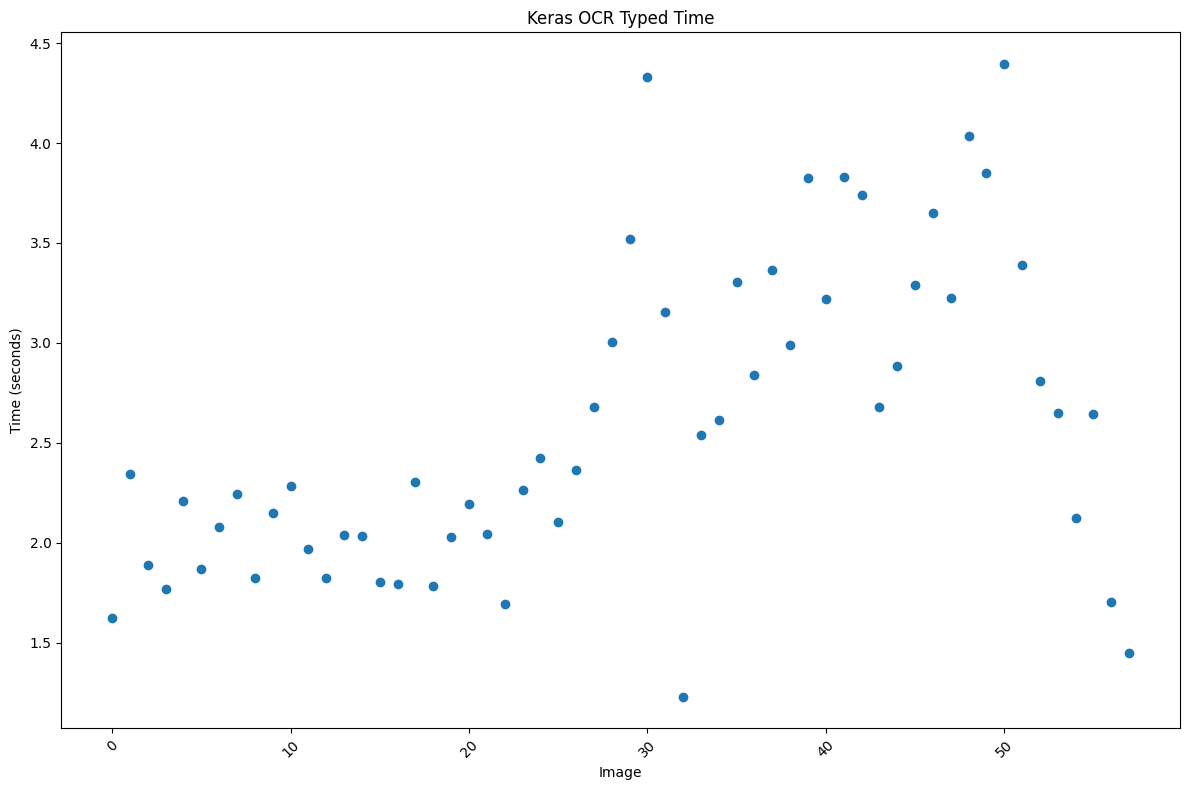

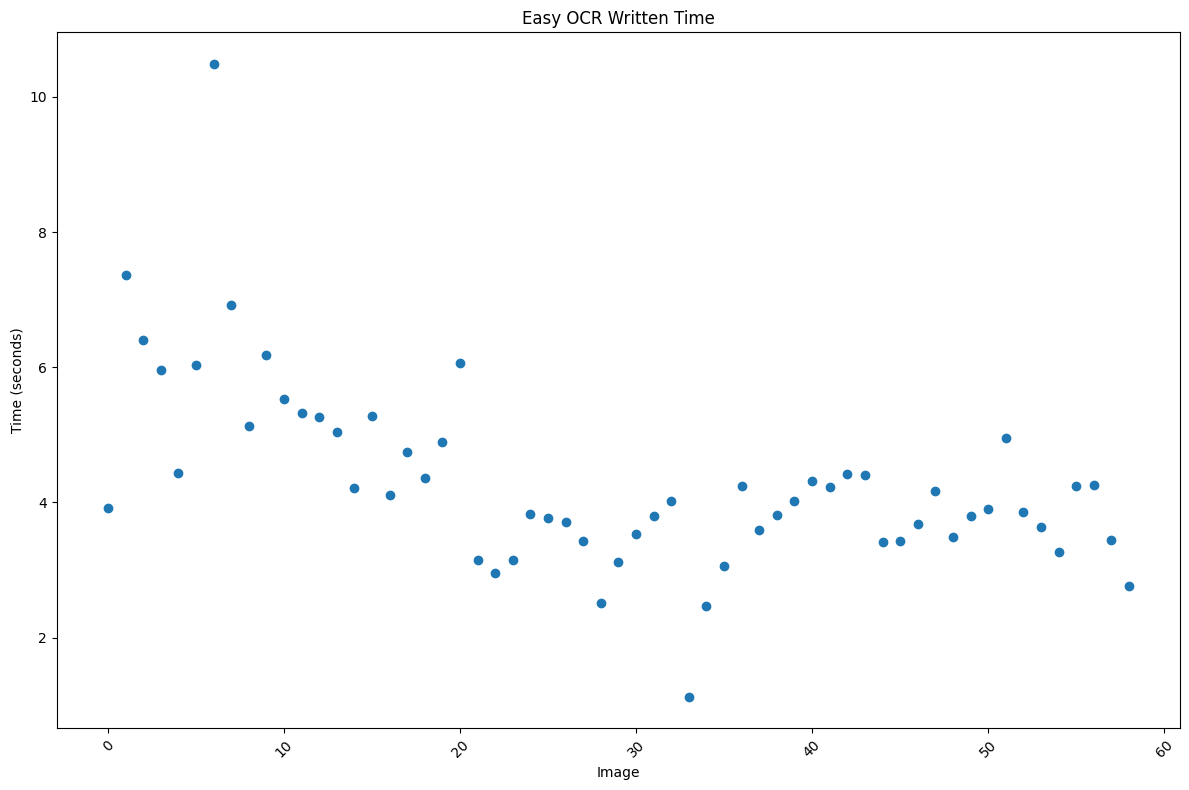

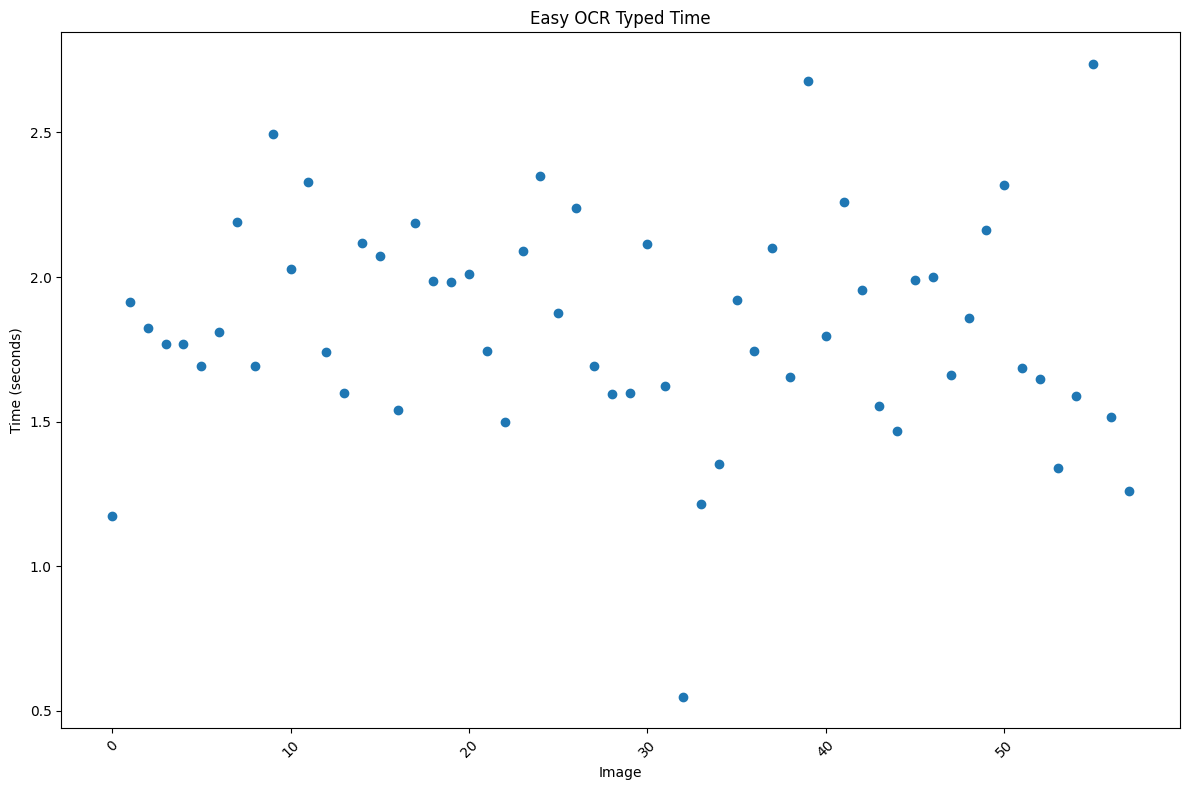

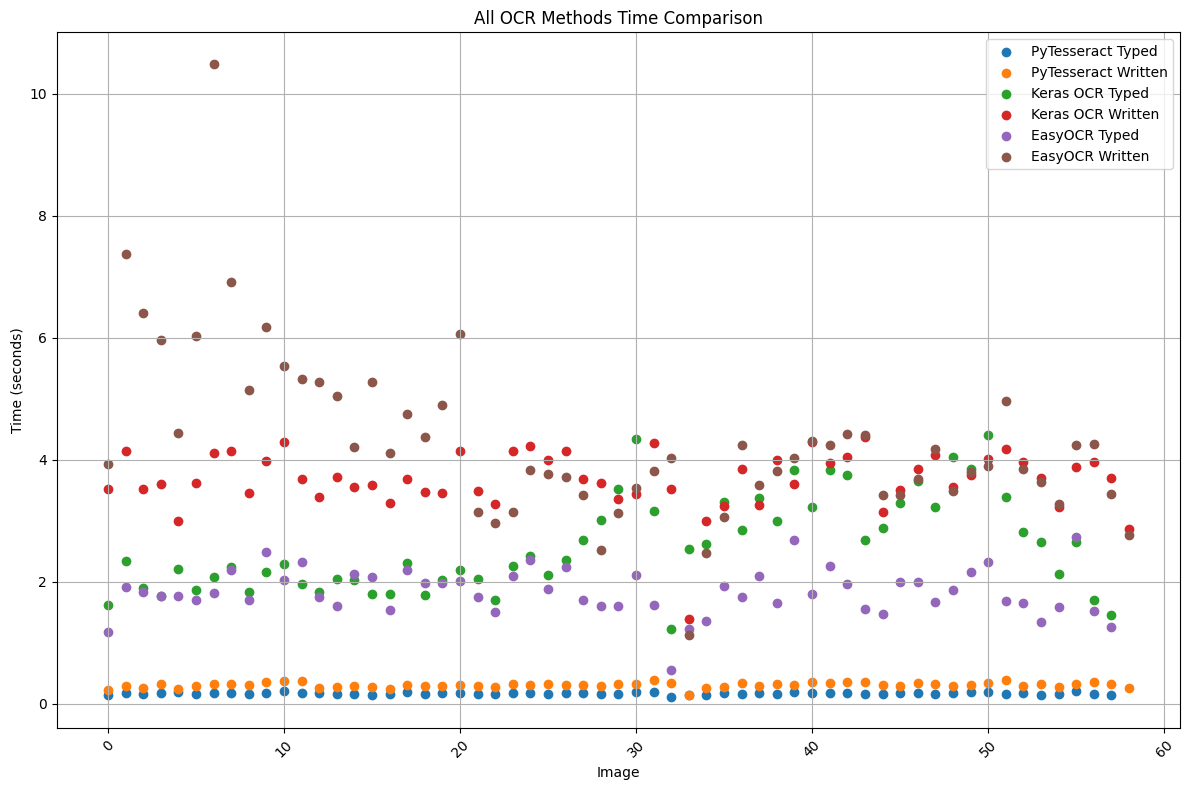

In [40]:
def plotTimes(times_dict, title):
    indices = range(len(times_dict))
    values = list(times_dict.values())
    plt.figure(figsize=(12, 8))
    plt.scatter(indices, values)
    plt.xlabel('Image')
    plt.ylabel('Time (seconds)')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plotAllTimes(lists, legend):
    plt.figure(figsize=(12, 8))
    for times_dict in lists:
        indices = range(len(times_dict))
        values = list(times_dict.values())
        plt.scatter(indices, values)
    plt.xlabel('Image')
    plt.ylabel('Time (seconds)')
    plt.title("All OCR Methods Time Comparison")
    plt.legend(legend, loc='upper right')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plotTimes(pyTesseractWrittenTime, "PyTesseract Written Time")
plotTimes(pyTesseractTypedTime, "PyTesseract Typed Time")
plotTimes(kerasWrittenTime, "Keras OCR Written Time")
plotTimes(kerasTypedTime, "Keras OCR Typed Time")
plotTimes(easyWrittenTime, "Easy OCR Written Time")
plotTimes(easyTypedTime, "Easy OCR Typed Time")

time_dicts = [pyTesseractTypedTime, pyTesseractWrittenTime, 
              kerasTypedTime, kerasWrittenTime,
              easyTypedTime, easyWrittenTime]

titles = ['PyTesseract Typed', 'PyTesseract Written',
          'Keras OCR Typed', 'Keras OCR Written',
          'EasyOCR Typed', 'EasyOCR Written']

plotAllTimes(time_dicts, titles)

In [41]:
#Clean data
print("Processing images in directory (PyTesseract):", imageWritten)
pyTesseractWrittenTime= processImagesPyTesseract(imageWritten, "pyWrittenCleaned", True)
print("\nProcessing images in directory  (PyTesseract):", imageTyped)
pyTesseractTypedTime=processImagesPyTesseract(imageTyped, "pyTypedCleaned", True)

print("Processing images in directory (Keras OCR):", imageWritten)
kerasWrittenTimeClean=processImagesKerasOcr(imageWritten, "kerasWrittenCleaned", True)
print("\nProcessing images in directory (Keras OCR):", imageTyped)
kerasTypedTimeClean=processImagesKerasOcr(imageTyped, "kerasTypedCleaned", True)

print("Processing images in directory (Easy OCR):", imageWritten)
easyWrittenTime=processImagesEasyOcr(imageWritten, "easy-ocrWrittenCleaned", True)
print("\nProcessing images in directory (Easy OCR):", imageTyped)
easyTypedTime=processImagesEasyOcr(imageTyped, "easy-ocrTypedCleaned", True)


groundTruth = 'cleaned/000-truth'
pyTesseractOutputTypedCleaned = 'outputs/pyTypedCleaned'
pyTesseractOutputWrittenCleaned = 'outputs/pyWrittenCleaned'
kerasOCROutputTypedCleaned = 'outputs/kerasTypedCleaned'
kerasOCROutputWrittenCleaned = 'outputs/kerasWrittenCleaned'
easyOCROutputTypedCleaned = 'outputs/easy-ocrTypedCleaned'
easyOCROutputWrittenCleaned = 'outputs/easy-ocrWrittenCleaned'
result = loadDataAll(groundTruth, pyTesseractOutputTypedCleaned, pyTesseractOutputWrittenCleaned, kerasOCROutputTypedCleaned, kerasOCROutputWrittenCleaned, easyOCROutputTypedCleaned, easyOCROutputWrittenCleaned)


Processing images in directory (PyTesseract): cleaned/000-written
Text extracted from a01-000.png and saved to outputs/pyWrittenCleaned/a01-000.txt
Text extracted from a01-003.png and saved to outputs/pyWrittenCleaned/a01-003.txt
Text extracted from a01-007.png and saved to outputs/pyWrittenCleaned/a01-007.txt
Text extracted from a01-011.png and saved to outputs/pyWrittenCleaned/a01-011.txt
Text extracted from a01-014.png and saved to outputs/pyWrittenCleaned/a01-014.txt
Text extracted from a01-020.png and saved to outputs/pyWrittenCleaned/a01-020.txt
Text extracted from a01-026.png and saved to outputs/pyWrittenCleaned/a01-026.txt
Text extracted from a01-030.png and saved to outputs/pyWrittenCleaned/a01-030.txt
Text extracted from a01-043.png and saved to outputs/pyWrittenCleaned/a01-043.txt
Text extracted from a01-049.png and saved to outputs/pyWrittenCleaned/a01-049.txt
Text extracted from a01-049x.png and saved to outputs/pyWrittenCleaned/a01-049x.txt
Text extracted from a01-053.pn

# Models

In [42]:
#PyTesseract
#Doesn't used a Deep learning model like EasyOCR, so cannot evaluate parameters

In [43]:
#Keras OCR
print(pipeline.detector.model.summary())

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 basenet.slice1.0 (Conv2D)      (None, None, None,   1792        ['input_6[0][0]']                
                                64)                                                               
                                                                                                  
 basenet.slice1.1 (BatchNormali  (None, None, None,   256        ['basenet.slice1.0[0][0]']       
 zation)                        64)                                                         

In [44]:
print(pipeline.recognizer.model.summary())

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 31, 200, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 permute_1 (Permute)            (None, 200, 31, 1)   0           ['input_7[0][0]']                
                                                                                                  
 lambda_4 (Lambda)              (None, 200, 31, 1)   0           ['permute_1[0][0]']              
                                                                                                  
 conv_1 (Conv2D)                (None, 200, 31, 64)  640         ['lambda_4[0][0]']        

In [45]:
#Easy OCR
model = reader.recognizer 
print(model)

Model(
  (FeatureExtraction): VGG_FeatureExtractor(
    (ConvNet): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): ReLU(inplace=True)
      

In [46]:
for name, param in model.named_parameters():
    print(name, param.shape)

FeatureExtraction.ConvNet.0.weight torch.Size([32, 1, 3, 3])
FeatureExtraction.ConvNet.0.bias torch.Size([32])
FeatureExtraction.ConvNet.3.weight torch.Size([64, 32, 3, 3])
FeatureExtraction.ConvNet.3.bias torch.Size([64])
FeatureExtraction.ConvNet.6.weight torch.Size([128, 64, 3, 3])
FeatureExtraction.ConvNet.6.bias torch.Size([128])
FeatureExtraction.ConvNet.8.weight torch.Size([128, 128, 3, 3])
FeatureExtraction.ConvNet.8.bias torch.Size([128])
FeatureExtraction.ConvNet.11.weight torch.Size([256, 128, 3, 3])
FeatureExtraction.ConvNet.12.weight torch.Size([256])
FeatureExtraction.ConvNet.12.bias torch.Size([256])
FeatureExtraction.ConvNet.14.weight torch.Size([256, 256, 3, 3])
FeatureExtraction.ConvNet.15.weight torch.Size([256])
FeatureExtraction.ConvNet.15.bias torch.Size([256])
FeatureExtraction.ConvNet.18.weight torch.Size([256, 256, 2, 2])
FeatureExtraction.ConvNet.18.bias torch.Size([256])


In [47]:
# Number of trainable parameters in EasyOCR
# p.numel() returns the number in parameter tensor, example: (4, 3) = 12
trainable_params = sum(p.numel() for p in model.parameters())

print(f"Trainable parameters: {trainable_params}")

Trainable parameters: 1388416


# Training Keras (with our dataset)

In [48]:
def matchData(imageFolder, groundTruthFolder):
    imagesPath = []
    textsPath = []
    #Assumes they are in the same order in both and each exists in the other
    for image in os.listdir(imageFolder):
        imagesPath.append(os.path.join(imageFolder, image)) 
    for text in os.listdir(groundTruthFolder):
        textsPath.append(os.path.join(groundTruth, text))
    return imagesPath, textsPath

trainWritten = "cleaned/000-written-test"
trainTyped = "cleaned/000-typed-test"
trainTruth = "cleaned/000-typed-test"

trainWrittenPath, trainTestPathW = matchData(trainWritten, trainTruth)
trainTypedPath, trainTestPathT = matchData(trainTyped, trainTruth)

# two different models
writtenTrainingData = list(zip(trainWrittenPath,trainTestPathW))
typedTrainingData = list(zip(trainTypedPath, trainTestPathT))

pipeline = keras_ocr.pipeline.Pipeline()

def trainPipeline(name, trainData, epochs, batchSize =8):
    recognizer = pipeline.recognizer
    recognizer.compile()
    #recognizer.compile(optimizer=Adam(learning_rate=0.0001))

    #could not get recognizer.fit to work
    #kept getting "Recognizer has not attribute 'fit' "
    recognizer.fit(
        trainData,  #need zip list here FYI
        epochs,
        batchSize
    )
    recognizer.model.save(name+'.h5')

#need to finish
trainPipeline('written_model', writtenTrainingData, epochs=10, batchSize=8)
trainPipeline('typed_model', typedTrainingData, epochs=10, batchSize=8)


model = keras.models.load_model("written_model.h5")
pipeline = keras_ocr.pipeline.Pipeline(recognizer=model)
process = pipeline.recognize

processImagesKerasOcr(imageDirectory, outputDirectory, process):
#FYI fix names here later and make it do for both
#also add names for the output directories


SyntaxError: invalid syntax (3906350459.py, line 47)